# Painter by Numbers Patches

In [1]:
cp -r /tf/code/* .

In [2]:
from core.boot import *

gpus_with_memory_growth()
dst = appropriate_distributed_strategy()

Number of devices: 0


In [3]:
import os

import numpy as np
import tensorflow as tf

from core.datasets import pbn
from core.utils import *

In [4]:
base_dir = os.environ.get('SCRATCH', '/tf/scratch')

data_dir = os.environ.get('DATA_DIR', '/tf/data/painter-by-numbers')
logs_dir = os.environ.get('LOGS_DIR', os.path.join(base_dir, 'painting-by-numbers', 'logs'))
weights_dir = os.environ.get('WEIGHTS_DIR', os.path.join(base_dir, 'painting-by-numbers', 'models'))


class ExperimentConfig:
  base_dir = base_dir

  np_seed = 21416
  tf_seed = 4769

class DataConfig:
  all_info   = f'{data_dir}/meta/all_data_info.csv'
  train_info = f'{data_dir}/meta/train_info.csv'
  train_records = f'{data_dir}/train.tfrecords'
  test_records  = f'{data_dir}/test.tfrecords'

  size                 = (299, 299)
  shape                = (*size, 3)
  patches                = int(os.environ.get('PATCHES', '20'))
  batch_size_per_replica = int(os.environ.get('BATCH', '128'))
  batch_size           = 128 * dst.num_replicas_in_sync
  shuffle_buffer_size  = 48 * batch_size
  prefetch_buffer_size = tf.data.experimental.AUTOTUNE
  shuffle_seed         = 2142

  valid_size = 0.3
  shards = 32

  preprocess = tf.keras.applications.inception_v3.preprocess_input
  deprocess = lambda x: (x + 1) * 127.5
  to_image = lambda x: tf.cast(tf.clip_by_value(DataConfig.deprocess(x), 0, 255), tf.uint8)

  class aug:
    brightness_delta =  .2
    saturation_lower =  .5
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0

  R = tf.random.Generator.from_seed(ExperimentConfig.tf_seed, alg='philox')
  np.random.seed(ExperimentConfig.np_seed)

In [5]:
print('\n[Painter by Numbers] loading')

info = pbn.PainterByNumbers.load_info(DataConfig.all_info, DataConfig.train_info)

dataset = tf.data.TFRecordDataset(DataConfig.train_records)
dataset = dataset.apply(tf.data.experimental.assert_cardinality(pbn.PainterByNumbers.num_train_samples))

shards_t = int((1 - DataConfig.valid_size) * DataConfig.shards)
shards_v = DataConfig.shards - shards_t

train_steps = shards_t * (pbn.PainterByNumbers.num_train_samples // DataConfig.shards) // DataConfig.batch_size
valid_steps = shards_v * (pbn.PainterByNumbers.num_train_samples // DataConfig.shards) // DataConfig.batch_size


[Painter by Numbers] loading


In [6]:
train = pbn.prepare(dataset, shards_t, shard_0=0, augment=True, config=DataConfig)
valid = pbn.prepare(dataset, shards_v, shards_t, augment=False)

[load_fn trace] d:dict_keys(['artist_group', 'artist_hash', 'artist_hash_code', 'date', 'filename', 'genre', 'genre_code', 'height', 'image', 'size', 'source', 'style', 'style_code', 'title', 'width']) sizes:Tensor("patch_shape:0", shape=(3,), dtype=int32)


In [7]:
train = train.repeat()
valid = valid.repeat()

In [ ]:
for a, b in train.take(1):
    ...

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'dict'>


In [12]:
for c, d in train.take(1):
    ...

In [13]:
for e, f in train.take(1):
    ...

In [ ]:
visualize([*(127.5*(a[:32].numpy()+1)).astype('uint8')], rows=4, figsize=(16, 8))

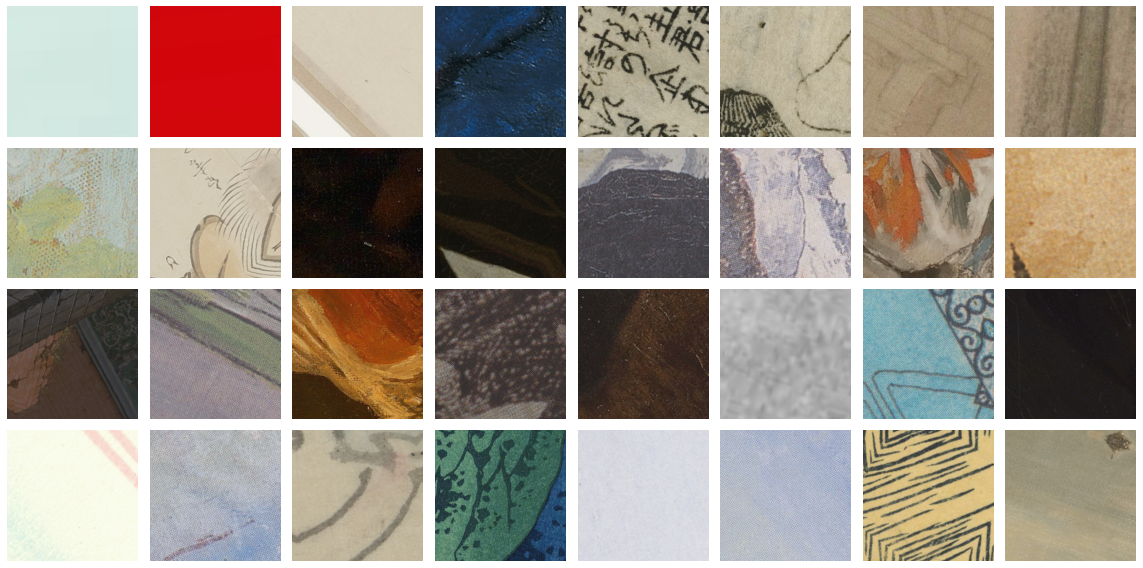

In [15]:
visualize([*(127.5*(c[:32].numpy()+1)).astype('uint8')], rows=4, figsize=(16, 8))

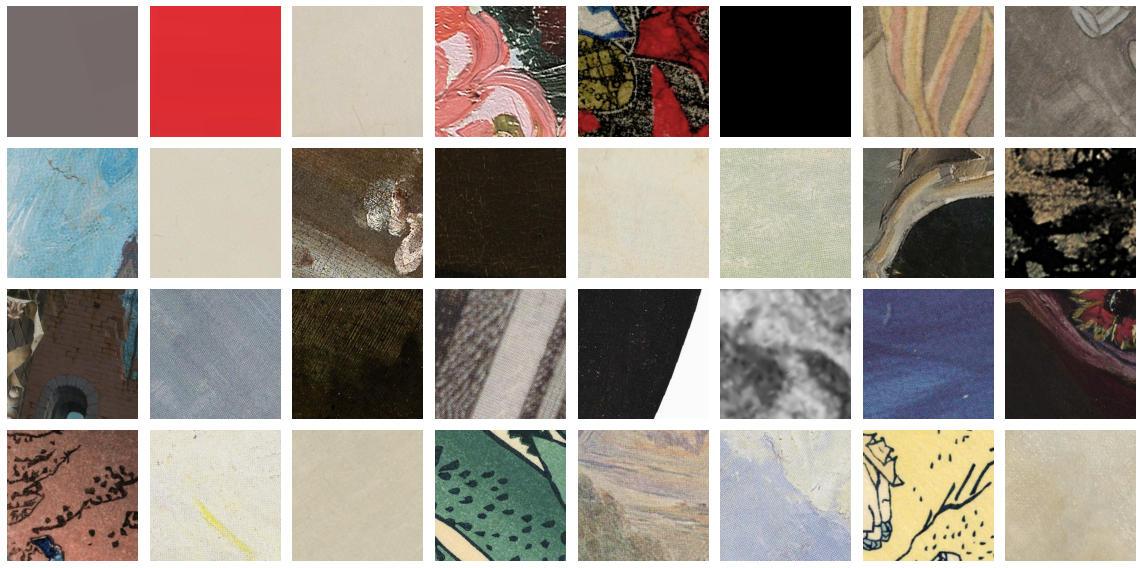

In [16]:
visualize([*(127.5*(e[:32].numpy()+1)).astype('uint8')], rows=4, figsize=(16, 8))

In [17]:
print(b['artist'][:32], d['artist'][:32], f['artist'][:32], sep='\n')

tf.Tensor(
[ 539  539  914    1  859  859 1066 1066 1349  914  389  617  694  694
  918 1422  956  694  744  410  272 1267  410 1423 1162  694 1162 1162
  555  694 1162 1550], shape=(32,), dtype=int64)
tf.Tensor(
[ 539  539  914    1  859  859 1066 1066 1349  914  389  617  694  694
  918 1422  956  694  744  410  272 1267  410 1423 1162  694 1162 1162
  555  694 1162 1550], shape=(32,), dtype=int64)
tf.Tensor(
[ 539  539  914    1  859  859 1066 1066 1349  914  389  617  694  694
  918 1422  956  694  744  410  272 1267  410 1423 1162  694 1162 1162
  555  694 1162 1550], shape=(32,), dtype=int64)
